<h2>Классификация поколений покемонов</h2>

In [30]:
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use("ggplot")
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
os.getcwd()

'D:\\DSTU\\практика ИИ\\PokemonNet\\net'

In [5]:
os.chdir('..')

<h3>Чистка датасета</h3>

In [33]:
data = pd.read_csv('datasets/pokemon.csv')
data.shape

(801, 41)

In [34]:
data = data[["name","generation"]]
data = data.sort_values(by=['name'], ascending=True).reset_index(drop=True)

In [35]:
data['generation'] = data['generation'].map(lambda x: str(x))

In [36]:
data['name'] = data['name'].str.lower()

In [37]:
data

,name,generation
0,abomasnow,4
1,abra,1
2,absol,3
3,accelgor,5
4,aegislash,6
...,...,...
796,zoroark,5
797,zorua,5
798,zubat,1
799,zweilous,5


<h4>Выводим информацию о поколениях первых четырех покемонов</h4>

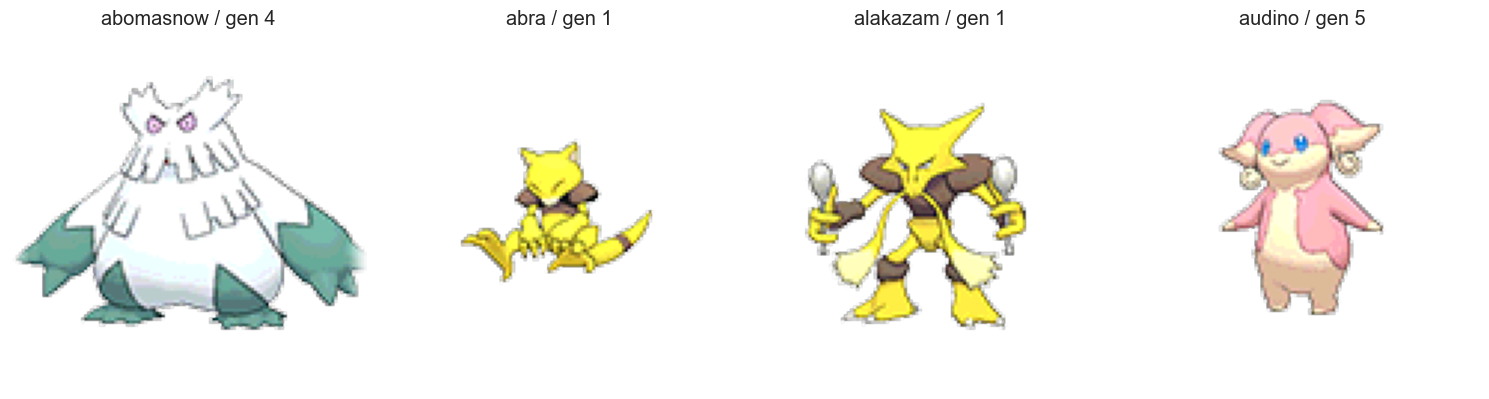

In [38]:
import matplotlib.image as mpimg
path = os.path.join('images/')
fig,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
ax = [ax1, ax2, ax3, ax4]
for i in range(4):
    img = mpimg.imread(path+data['name'][i**3]+'.png')
    ax[i].imshow(img)
    ax[i].set_title(f'{data['name'][i**3]} / gen {data['generation'][i**3]}')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

<h4>Создаем датасет на основе расположения изображений</h4>

In [39]:
path=os.path.join('images/')
img_name = sorted(os.listdir(path))
img_paths = []
for i in img_name:
    name = i.split('.')[0]
    img_paths.append({'name': name, 'path': path + i})
image_df = pd.DataFrame(img_paths)

In [40]:
# Сопостовляем новый датасет с исходным
data=data.merge(image_df,how='inner', on='name')

In [41]:
data.head()

,name,generation,path
0,abomasnow,4,images/abomasnow.png
1,abra,1,images/abra.png
2,absol,3,images/absol.png
3,accelgor,5,images/accelgor.png
4,aerodactyl,1,images/aerodactyl.png


Text(0, 0.5, 'Число изображений')

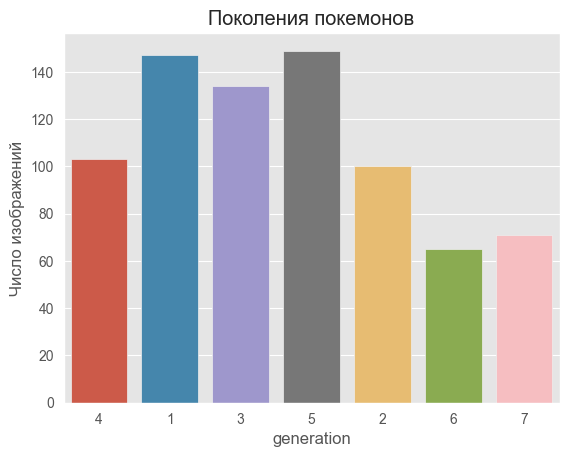

In [42]:
sns.countplot(x=data.generation, hue='generation', data=data,)
plt.title('Поколения покемонов')
plt.ylabel('Число изображений')

In [43]:
data.generation.value_counts()

generation
5    149
1    147
3    134
4    103
2    100
7     71
6     65
Name: count, dtype: int64

In [44]:
NUM_CLASSES = 7
classes = [str(i + 1) for i in range(NUM_CLASSES)]
classes

['1', '2', '3', '4', '5', '6', '7']

<h4>Аугментируем изображения датасета с помощью генератора</h4>

In [46]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1)
# Генератор из обучающего датасета
train_generator = train_datagenerator.flow_from_dataframe(
    data,
    x_col='path',
    y_col='generation',
    target_size=(120, 120),
    color_mode='rgba',
    classes = classes,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='training')
# Генератор из тренировочного датасета
validation_generator = train_datagenerator.flow_from_dataframe(
    data ,
    x_col='path',
    y_col='generation',
    target_size=(120, 120),
    color_mode='rgba',
    classes = classes,
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=1,
    subset='validation'
)

Found 693 validated image filenames belonging to 7 classes.
Found 76 validated image filenames belonging to 7 classes.


<h4>Проверяем дополненный датасет</h4>

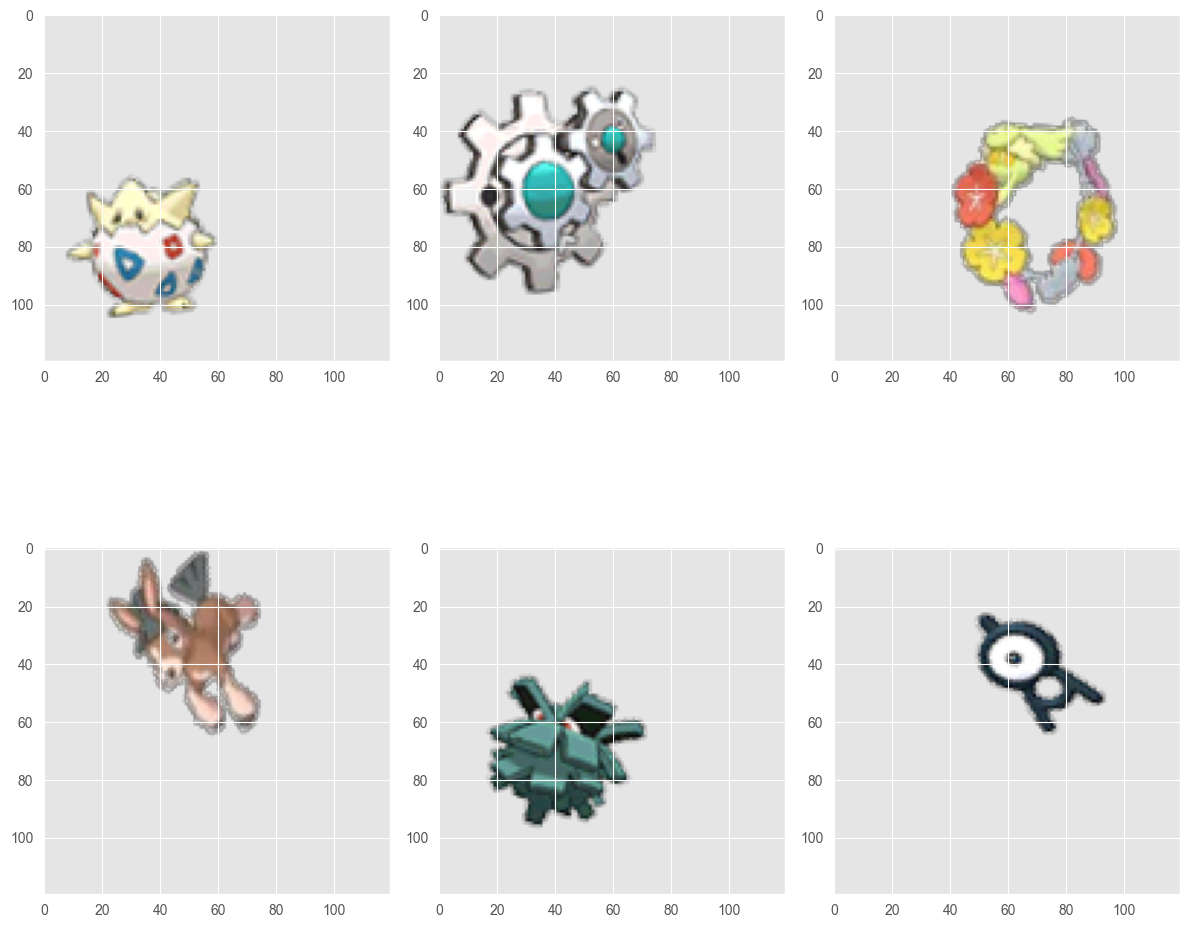

In [47]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

<h4>Модель сверточной сети: <u>D + (CV + MP)^3 + DO + F + D + S</u></h4>

In [48]:
model = ks.models.Sequential()
model.add(ks.layers.Dense(4, input_shape=(120,120,4)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Flatten())

model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(NUM_CLASSES, activation='softmax'))

In [50]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 120, 120, 4)    │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 118, 118, 64)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,666,971 (55.95 MB)

 Trainable params: 14,666,971 (55.95 MB)

 Non-trainable params: 0 (0.00 B)

<h4>Обучаем модель на 50 эпохах</h4>

In [51]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 753ms/step - accuracy: 0.2001 - loss: 2.2395 - val_accuracy: 0.1711 - val_loss: 1.9257
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 760ms/step - accuracy: 0.1656 - loss: 1.9197 - val_accuracy: 0.1579 - val_loss: 1.9456
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 782ms/step - accuracy: 0.2110 - loss: 1.8935 - val_accuracy: 0.1974 - val_loss: 1.9178
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 769ms/step - accuracy: 0.2320 - loss: 1.8881 - val_accuracy: 0.1579 - val_loss: 1.9155
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - accuracy: 0.1911 - loss: 1.8861 - val_accuracy: 0.1447 - val_loss: 1.9019
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 794ms/step - accuracy: 0.2255 - loss: 1.8375 - val_accuracy: 0.2500 - val_loss: 1.7894
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 825ms/step - accuracy: 0.2804 - loss: 1.6774 - val_accuracy: 0.2368 - val_loss: 1.7162
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 756ms/step - accuracy: 0.2933 - loss: 1.6195 - val_accu

<h4>Сохраняем модель и график точности</h4>

In [52]:
model.save('models/generation/best/model.h5')

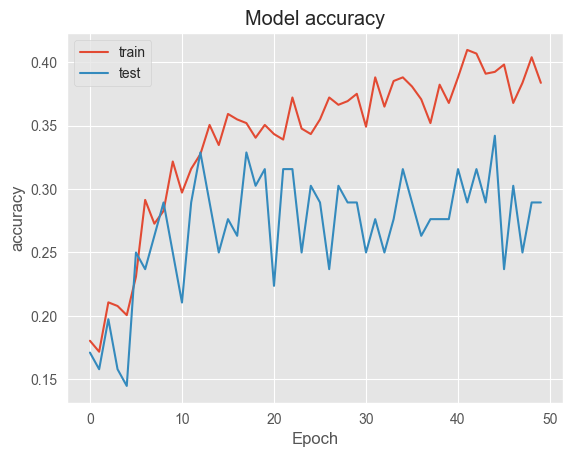

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.savefig('models/generation/best/accuracy.png')

<h4>Проверяем модель на изображении покемона</h4>

In [54]:
def predict(model, image_path):
    image = mpimg.imread(image_path)
    image = np.expand_dims(image, axis=0)
    return model.predict(image)

In [55]:
def predict_gen(model, img_path):
    label = img_path.split('/')[-1].split('.')[0]
    prediction = predict(model, img_path)[0]
    result = {classes[i]: prediction[i] for i in range(len(prediction))}
    print(f'{label} поколение: {result}')

In [57]:
predict_gen(model, 'images/braixen.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
braixen поколение: {'1': 0.03993697, '2': 0.1305282, '3': 0.04115725, '4': 0.08410355, '5': 0.21777533, '6': 0.4864987, '7': 5.3697324e-10}
